In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, fbeta_score

In [ ]:
df=pd.read_csv('/content/Airline_Delay_Cause (1).csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179338 entries, 0 to 179337
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 179338 non-null  int64  
 1   month                179338 non-null  int64  
 2   carrier              179338 non-null  object 
 3   carrier_name         179338 non-null  object 
 4   airport              179338 non-null  object 
 5   airport_name         179338 non-null  object 
 6   arr_flights          178997 non-null  float64
 7   arr_del15            178747 non-null  float64
 8   carrier_ct           178997 non-null  float64
 9   weather_ct           178997 non-null  float64
 10  nas_ct               178997 non-null  float64
 11  security_ct          178997 non-null  float64
 12  late_aircraft_ct     178997 non-null  float64
 13  arr_cancelled        178997 non-null  float64
 14  arr_diverted         178997 non-null  float64
 15  arr_delay        

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,179338.0,2019.480082,2.410204,2015.0,2018.00,2020.00,2022.00,2023.00
month,179338.0,6.485725,3.463516,1.0,3.00,6.00,9.00,12.00
arr_flights,178997.0,327.816969,931.001446,1.0,41.00,89.00,218.00,21977.00
arr_del15,178747.0,58.709086,164.378035,0.0,6.00,15.00,40.00,4176.00
carrier_ct,178997.0,18.572643,47.389651,0.0,1.96,5.40,14.70,1293.91
weather_ct,178997.0,2.035742,6.894812,0.0,0.00,0.22,1.62,266.42
nas_ct,178997.0,17.094929,56.279604,0.0,1.00,3.30,9.86,1884.42
security_ct,178997.0,0.145307,0.702149,0.0,0.00,0.00,0.00,58.69
late_aircraft_ct,178997.0,20.778477,64.912766,0.0,1.00,4.29,13.01,2069.07
arr_cancelled,178997.0,6.830103,41.446756,0.0,0.00,1.00,3.00,4951.00


In [ ]:
df.isnull().sum()

,0
year,0
month,0
carrier,0
carrier_name,0
airport,0
airport_name,0
arr_flights,341
arr_del15,591
carrier_ct,341
weather_ct,341


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
cols_to_sum = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']

# Sum the components
df['components_sum'] = df[cols_to_sum].sum(axis=1)

# Find rows where arr_del15 is not within ±1 of the components sum
mismatched_rows = df[
    (df['arr_del15'] >= df['components_sum'] + 1) |
    (df['arr_del15'] <= df['components_sum'] - 1)
]

# Show result
print("Number of mismatched rows:", len(mismatched_rows))
display(mismatched_rows.head())


Number of mismatched rows: 6


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,components_sum
2476,2023,11,F9,Frontier Airlines,CLE,"Cleveland, OH: Cleveland-Hopkins International",492.0,99.0,31.82,0.12,...,32.24,0.0,0.0,6934.0,3313.0,7.0,1140.0,0.0,2420.0,97.99
5228,2023,10,UA,United Air Lines Network,DCA,"Washington, DC: Ronald Reagan Washington National",538.0,56.0,22.02,0.74,...,13.61,1.0,1.0,3006.0,976.0,46.0,546.0,0.0,1207.0,54.99
63628,2021,3,F9,Frontier Airlines,STL,"St. Louis, MO: St Louis Lambert International",87.0,17.0,2.59,0.00,...,4.87,3.0,0.0,559.0,99.0,0.0,261.0,0.0,179.0,16.00
75724,2020,8,DL,Delta Air Lines Network,SEA,"Seattle, WA: Seattle/Tacoma International",1842.0,127.0,52.19,6.54,...,28.48,6.0,1.0,7690.0,4059.0,269.0,1203.0,21.0,1629.0,126.00
92426,2019,12,ZW,Air Wisconsin Airlines Corp,AZO,"Kalamazoo, MI: Kalamazoo/Battle Creek Internat...",84.0,22.0,5.03,0.00,...,10.16,0.0,2.0,1591.0,301.0,0.0,466.0,0.0,824.0,20.99


here i drop the columns with missing values because if i randomly fill the data then the relation between the columns doesnt hold true

And also there are very less columns with missing values

In [ ]:
numerical_columns = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
                     'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
                     'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
                     'security_delay', 'late_aircraft_delay']

df= df.dropna(subset=numerical_columns)

print(f"total columns After dropping missing: {len(df)}")


total columns After dropping missing: 178747


In [ ]:
df.isnull().sum()

,0
year,0
month,0
carrier,0
carrier_name,0
airport,0
airport_name,0
arr_flights,0
arr_del15,0
carrier_ct,0
weather_ct,0


In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

<Axes: xlabel='arr_delay', ylabel='Density'>

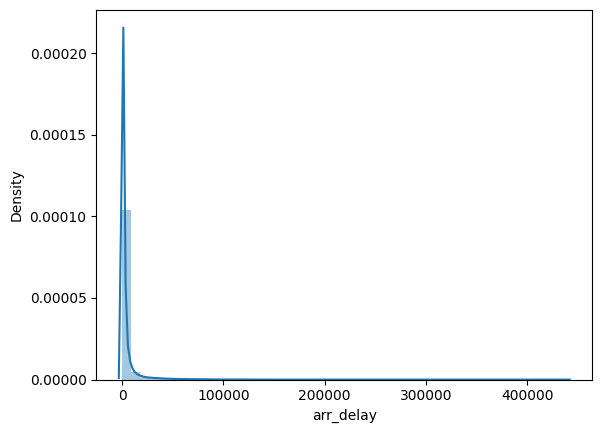

In [ ]:
sns.distplot(df['arr_delay'])

only some of the airlines got delayed out of total arrivals so i will make the new columns on the basis of the ratio w.r.t the arrival_flights

In [ ]:

df['delayed_ratio'] = (df['arr_del15'] / df['arr_flights'])
df['carrier_ratio'] = df['carrier_ct'] / df['arr_flights']
df['weather_ratio'] = df['weather_ct'] / df['arr_flights']
df['nas_ratio'] = df['nas_ct'] / df['arr_flights']
df['security_ratio'] = df['security_ct'] / df['arr_flights']
df['late_aircraft_ratio'] = df['late_aircraft_ct'] / df['arr_flights']

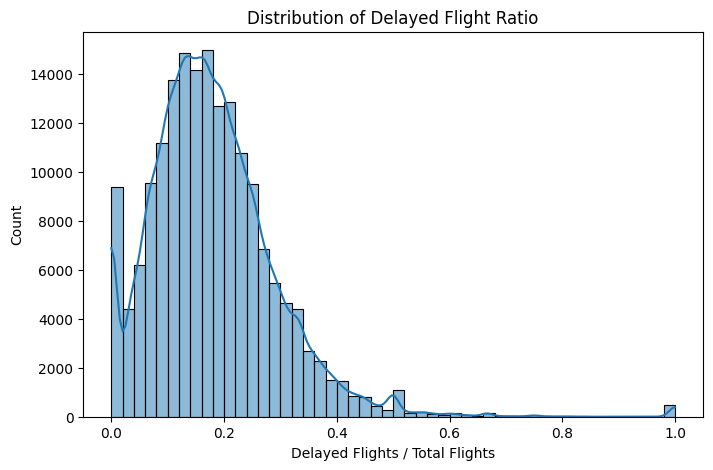

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['delayed_ratio'], bins=50, kde=True)
plt.title("Distribution of Delayed Flight Ratio")
plt.xlabel("Delayed Flights / Total Flights")
plt.show()

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
year,178747.0,2019.478604,2015.0,2018.0,2020.0,2022.0,2023.0,2.412093
month,178747.0,6.488411,1.0,3.0,6.0,10.0,12.0,3.464885
arr_flights,178747.0,328.263244,1.0,41.0,89.0,218.0,21977.0,931.57555
arr_del15,178747.0,58.709086,0.0,6.0,15.0,40.0,4176.0,164.378035
carrier_ct,178747.0,18.598619,0.0,1.97,5.42,14.73,1293.91,47.417686
weather_ct,178747.0,2.038589,0.0,0.0,0.22,1.63,266.42,6.899212
nas_ct,178747.0,17.118839,0.0,1.0,3.31,9.88,1884.42,56.315314
security_ct,178747.0,0.145511,0.0,0.0,0.0,0.0,58.69,0.702619
late_aircraft_ct,178747.0,20.807539,0.0,1.0,4.3,13.04,2069.07,64.95349
arr_cancelled,178747.0,6.827555,0.0,0.0,1.0,3.0,4951.0,41.471159


In [ ]:
# Step 1: Compute sum of components
cols_to_sum = ['arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
df['components_sum'] = df[cols_to_sum].sum(axis=1)

# Step 2: Extract year
df['year'] = pd.to_datetime(df['date']).dt.year

# Step 3: Compute yearly average ratio
df['arr_ratio'] = df['arr_flights'] / df['components_sum']
yearly_avg_ratio = df[df['components_sum'] > 0].groupby('year')['arr_ratio'].mean()

# Step 4: Replace where arr_flights < components_sum
def fix_arr_flights(row):
    if row['arr_flights'] < row['components_sum']:
        ratio = yearly_avg_ratio.get(row['year'], 1.0)  # fallback to 1.0 if missing
        return ratio * row['components_sum']
    else:
        return row['arr_flights']

df['arr_flights'] = df.apply(fix_arr_flights, axis=1)

# Optional cleanup
df.drop(columns=['components_sum', 'arr_ratio'], inplace=True)


## Exploratory Data Analysis

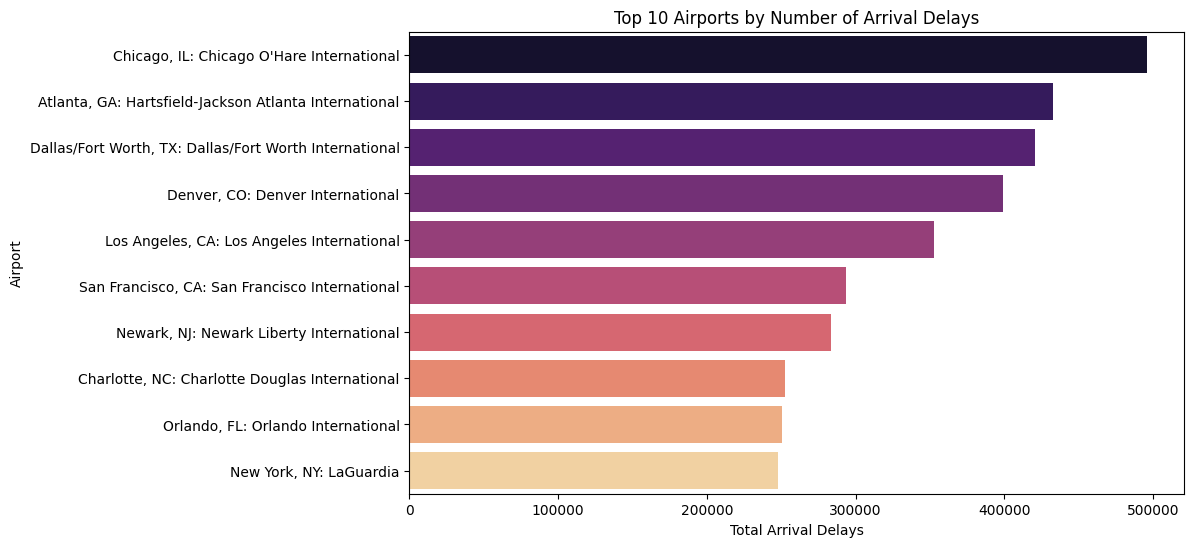

In [ ]:
top_airports = df.groupby('airport_name')['arr_del15'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_airports.values, y=top_airports.index, palette='magma')
plt.title("Top 10 Airports by Number of Arrival Delays")
plt.xlabel("Total Arrival Delays")
plt.ylabel("Airport")
plt.show()


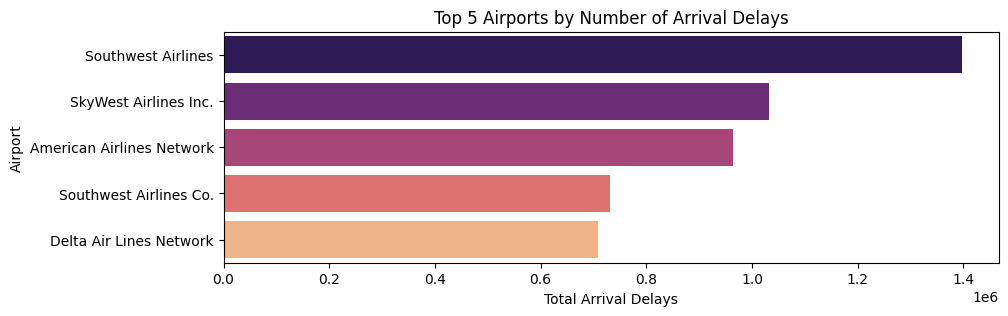

In [ ]:
top_airports = df.groupby('carrier_name')['arr_del15'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(10,3))
sns.barplot(x=top_airports.values, y=top_airports.index, palette='magma')
plt.title("Top 5 Airports by Number of Arrival Delays")
plt.xlabel("Total Arrival Delays")
plt.ylabel("Airport")
plt.show()

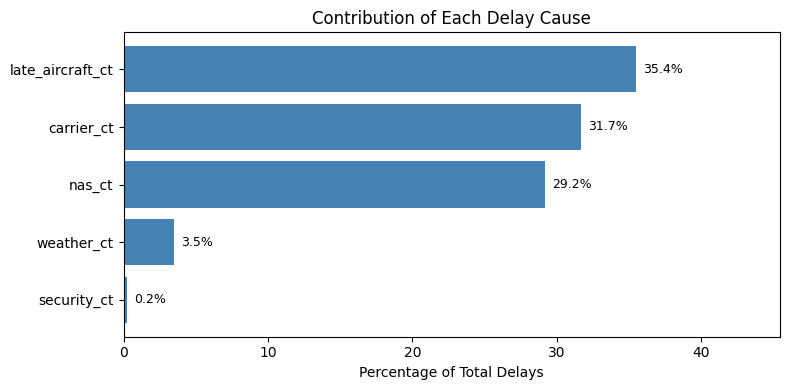

In [ ]:


cause_cols = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
cause_totals = df[cause_cols].sum()
cause_pct = 100 * cause_totals / cause_totals.sum()

# Sort values for consistent bar order
cause_pct_sorted = cause_pct.sort_values()

plt.figure(figsize=(8, 4))
bars = plt.barh(cause_pct_sorted.index, cause_pct_sorted.values, color='steelblue')
plt.xlabel("Percentage of Total Delays")
plt.title("Contribution of Each Delay Cause")

# Add percentage labels to the right of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontsize=9)

plt.xlim(0, max(cause_pct_sorted.values) + 10)  # Add margin for text
plt.tight_layout()
plt.show()


In [ ]:
df.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'date', 'delayed_ratio',
       'carrier_ratio', 'weather_ratio', 'nas_ratio', 'security_ratio',
       'late_aircraft_ratio'],
      dtype='object')

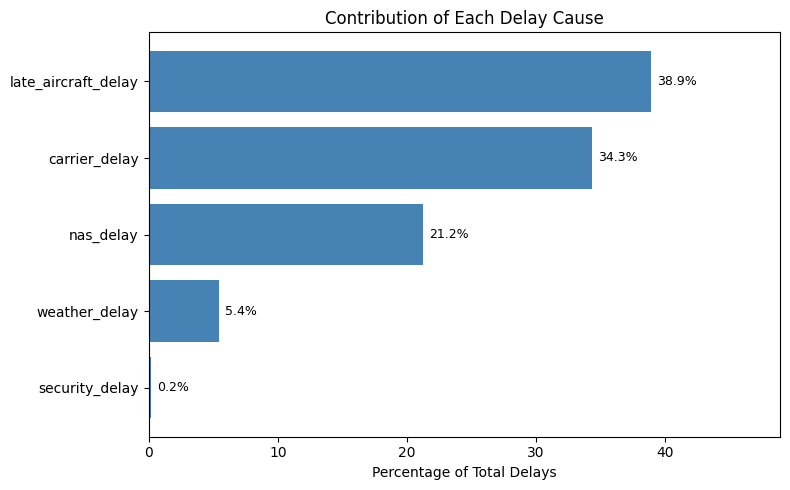

In [ ]:
cause_cols = ['carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay']
cause_totals = df[cause_cols].sum()
cause_pct = 100 * cause_totals / cause_totals.sum()

# Sort values for consistent bar order
cause_pct_sorted = cause_pct.sort_values()

plt.figure(figsize=(8, 5))
bars = plt.barh(cause_pct_sorted.index, cause_pct_sorted.values, color='steelblue')
plt.xlabel("Percentage of Total Delays")
plt.title("Contribution of Each Delay Cause")

# Add percentage labels to the right of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontsize=9)

plt.xlim(0, max(cause_pct_sorted.values) + 10)  # Add margin for text
plt.tight_layout()
plt.show()


we can clearly see that there are 3 major factor of delay

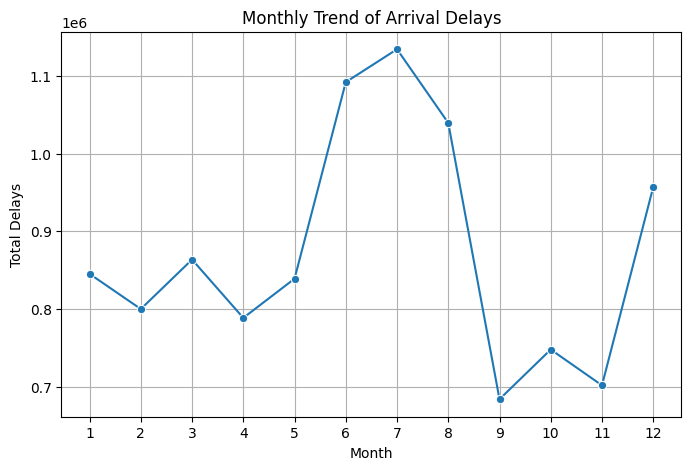

In [ ]:
df['month'] = pd.to_datetime(df['date']).dt.month
monthly_delays = df.groupby('month')['arr_del15'].sum()

plt.figure(figsize=(8,5))
sns.lineplot(x=monthly_delays.index, y=monthly_delays.values, marker='o')
plt.title("Monthly Trend of Arrival Delays")
plt.xlabel("Month")
plt.ylabel("Total Delays")
plt.xticks(range(1,13))
plt.grid(True)
plt.show()


mostly delay we see in middle months

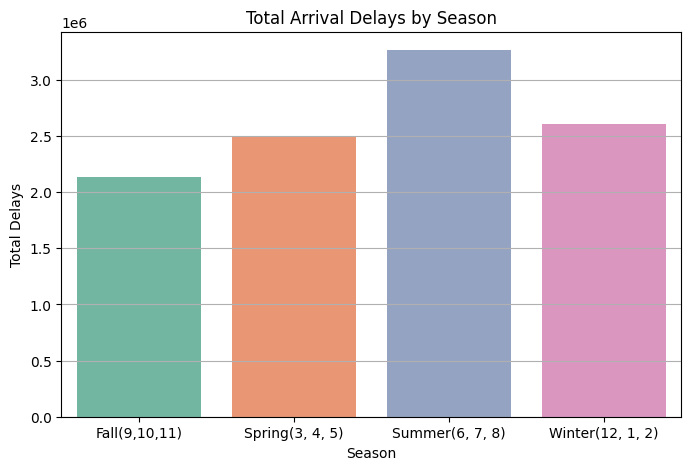

In [ ]:
#season wise delay
# Step 1: Define season mapping
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter(12, 1, 2)'
    elif month in [3, 4, 5]:
        return 'Spring(3, 4, 5)'
    elif month in [6, 7, 8]:
        return 'Summer(6, 7, 8)'
    else:
        return 'Fall(9,10,11)'

# Step 2: Apply season
df['season'] = df['month'].apply(get_season)

# Step 3: Group by season
seasonal_delays = df.groupby('season')['arr_del15'].sum()

# Step 4: Plot
plt.figure(figsize=(8,5))
sns.barplot(x=seasonal_delays.index, y=seasonal_delays.values, palette="Set2")
plt.title("Total Arrival Delays by Season")
plt.xlabel("Season")
plt.ylabel("Total Delays")
plt.grid(axis='y')
plt.show()


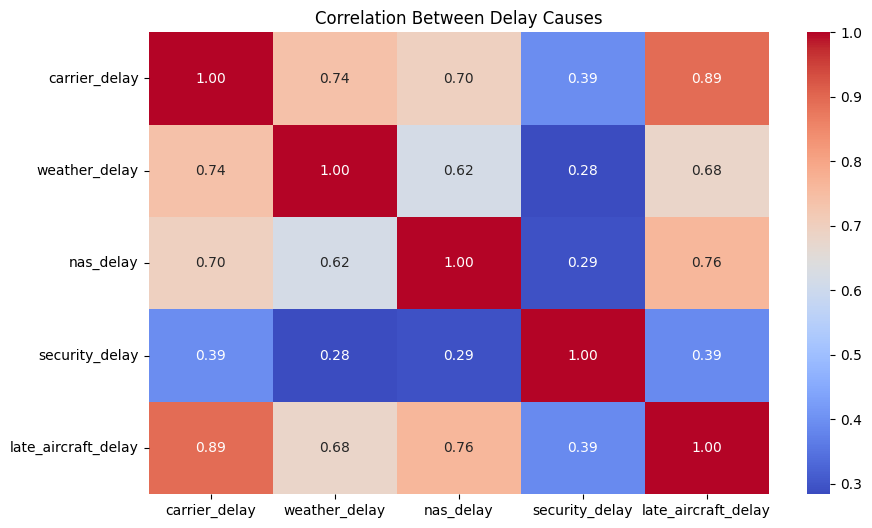

In [ ]:
plt.figure(figsize=(10, 6))
corr = df[['carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Delay Causes")
plt.show()


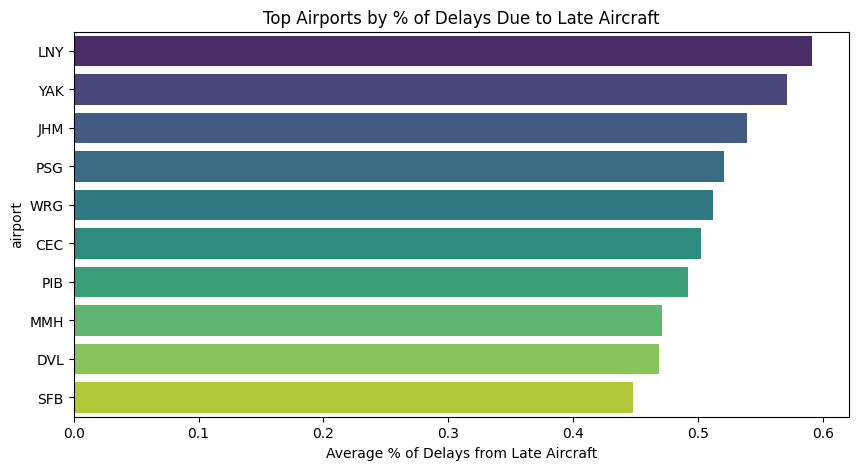

In [ ]:
df['late_aircraft_ratio'] = df['late_aircraft_ct'] / df['arr_del15'].replace(0, np.nan)
airport_ratio = df.groupby('airport')['late_aircraft_ratio'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=airport_ratio.values, y=airport_ratio.index, palette='viridis')
plt.title("Top Airports by % of Delays Due to Late Aircraft")
plt.xlabel("Average % of Delays from Late Aircraft")
plt.show()


<Figure size 1200x600 with 0 Axes>

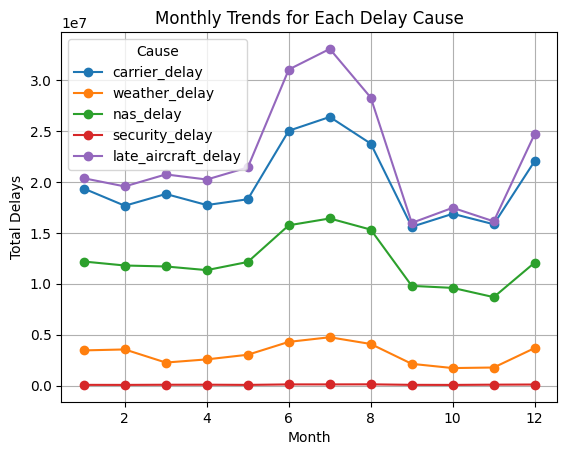

In [ ]:
monthly_cause = df.groupby('month')[cause_cols].sum()

plt.figure(figsize=(12,6))
monthly_cause.plot(kind='line', marker='o')
plt.title("Monthly Trends for Each Delay Cause")
plt.xlabel("Month")
plt.ylabel("Total Delays")
plt.grid(True)
plt.legend(title="Cause")
plt.show()


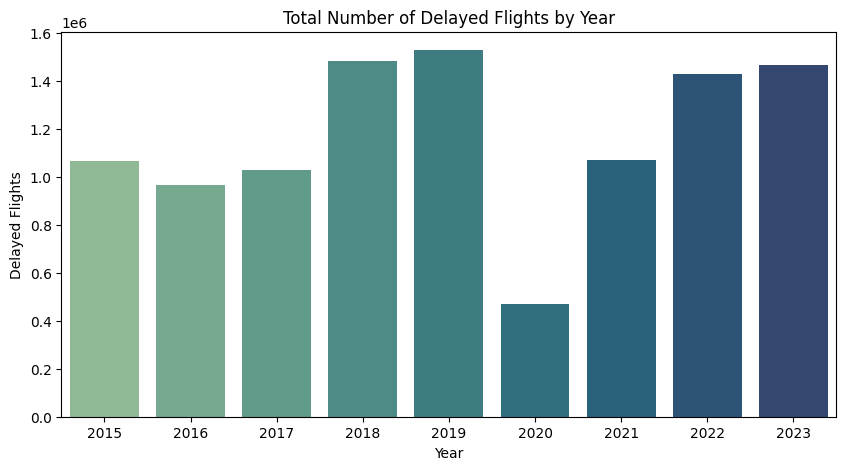

In [ ]:
df['year'] = pd.to_datetime(df['date']).dt.year
yearly_delays = df.groupby('year')['arr_del15'].sum()

plt.figure(figsize=(10,5))
sns.barplot(x=yearly_delays.index, y=yearly_delays.values, palette='crest')
plt.title("Total Number of Delayed Flights by Year")
plt.xlabel("Year")
plt.ylabel("Delayed Flights")
plt.show()


IN 2020 we see less delay may be because of  pandemic

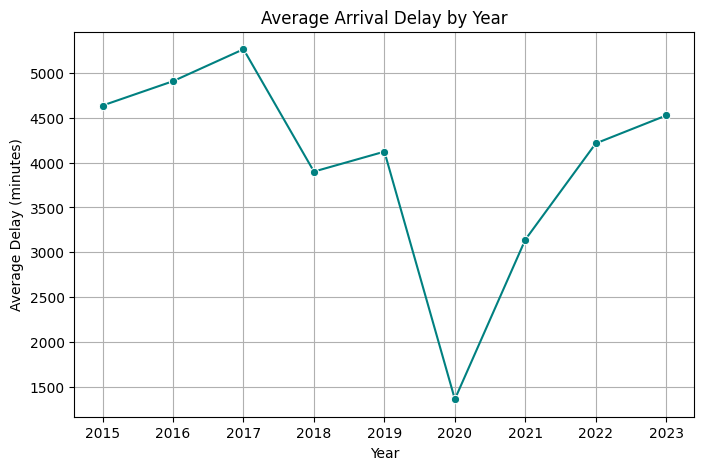

In [ ]:
avg_delay_per_year = df.groupby('year')['arr_delay'].mean()

plt.figure(figsize=(8,5))
sns.lineplot(x=avg_delay_per_year.index, y=avg_delay_per_year.values, marker='o', color='teal')
plt.title("Average Arrival Delay by Year")
plt.xlabel("Year")
plt.ylabel("Average Delay (minutes)")
plt.grid(True)
plt.show()

In [ ]:
df['is_delayed'] = (df['delayed_ratio'] > 0).astype(int)


In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
year,178747.0,2019.478604,2015.0,2018.0,2020.0,2022.0,2023.0,2.412093
month,178747.0,6.488411,1.0,3.0,6.0,10.0,12.0,3.464885
arr_flights,178747.0,329.371108,1.0,42.0,89.0,219.0,21977.0,932.209047
arr_del15,178747.0,58.709086,0.0,6.0,15.0,40.0,4176.0,164.378035
carrier_ct,178747.0,18.598619,0.0,1.97,5.42,14.73,1293.91,47.417686
weather_ct,178747.0,2.038589,0.0,0.0,0.22,1.63,266.42,6.899212
nas_ct,178747.0,17.118839,0.0,1.0,3.31,9.88,1884.42,56.315314
security_ct,178747.0,0.145511,0.0,0.0,0.0,0.0,58.69,0.702619
late_aircraft_ct,178747.0,20.807539,0.0,1.0,4.3,13.04,2069.07,64.95349
arr_cancelled,178747.0,6.827555,0.0,0.0,1.0,3.0,4951.0,41.471159


## Data Preprocessing

In [ ]:
# Drop unused columns
df = df.drop(columns=['carrier_name', 'airport_name'])

In [ ]:
df.columns

Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'date', 'delayed_ratio', 'carrier_ratio', 'weather_ratio', 'nas_ratio',
       'security_ratio', 'late_aircraft_ratio', 'season', 'is_delayed'],
      dtype='object')

In [ ]:
df['carrier'].unique()

array(['9E', 'AA', 'OH', 'OO', 'WN', 'AS', 'DL', 'PT', 'QX', 'UA', 'YV',
       'B6', 'F9', 'G4', 'G7', 'HA', 'MQ', 'YX', 'ZW', 'C5', 'NK', 'EM',
       'EV', 'AX', 'CP', 'KS', '9K', 'VX', 'US'], dtype=object)

In [ ]:
df['airport'].unique()

array(['ABE', 'AEX', 'AGS', 'ALB', 'ATL', 'ATW', 'AUS', 'AVL', 'AZO',
       'BDL', 'BGM', 'BGR', 'BHM', 'BMI', 'BNA', 'BOS', 'BTR', 'BTV',
       'BUF', 'BWI', 'CAE', 'CHA', 'CHO', 'CHS', 'CID', 'CLE', 'CLT',
       'CMH', 'CRW', 'CVG', 'CWA', 'DAY', 'DCA', 'DHN', 'DLH', 'DSM',
       'DTW', 'EWR', 'EYW', 'FAR', 'FAY', 'FLL', 'FSD', 'GFK', 'GNV',
       'GPT', 'GRB', 'GRR', 'GSO', 'GSP', 'GTR', 'HPN', 'HSV', 'IAD',
       'ICT', 'ILM', 'IND', 'ITH', 'JAN', 'JAX', 'JFK', 'LAN', 'LEX',
       'LFT', 'LGA', 'LIT', 'MCI', 'MDT', 'MEM', 'MGM', 'MIA', 'MKE',
       'MLI', 'MLU', 'MOB', 'MQT', 'MSN', 'MSP', 'MSY', 'MYR', 'OAJ',
       'OMA', 'ORD', 'ORF', 'ORH', 'PHL', 'PIT', 'PNS', 'PVD', 'PWM',
       'RDU', 'RIC', 'ROA', 'ROC', 'RST', 'RSW', 'SAV', 'SBN', 'SDF',
       'SGF', 'SHV', 'STL', 'SYR', 'TLH', 'TRI', 'TUL', 'TVC', 'TYS',
       'VLD', 'XNA', 'ABQ', 'AMA', 'ANC', 'AVP', 'BFL', 'BOI', 'BUR',
       'BZN', 'COS', 'DAB', 'DEN', 'DFW', 'ECP', 'MHT', 'MLB', 'OKC',
       'PHF', 'PIA',

In [ ]:
cls_features=[
    'year', 'month', 'carrier', 'airport',
    'arr_cancelled', 'arr_diverted', 'arr_flights'
]

reg_features = [
    'arr_cancelled', 'arr_diverted',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
    'year', 'month', 'carrier', 'airport', 'arr_flights'
]



In [ ]:
X = df[cls_features].copy()
y = df['is_delayed']

In [ ]:
le_carrier = LabelEncoder()
le_airport = LabelEncoder()
X['carrier'] = le_carrier.fit_transform(X['carrier'])
X['airport'] = le_airport.fit_transform(X['airport'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:

# Safety net before modeling
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # always use training stats


In [ ]:
# 📌 STEP 5: Feature Scaling
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##CLASSIFICATION MODELS

In [ ]:
# ✅ Logistic Regression
# -------------------------------
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)
y_probs = logreg.predict_proba(X_test_scaled)[:, 1]

y_pred_custom = (y_probs > 0).astype(int)

print("📊 Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_log))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
from sklearn.metrics import accuracy_score

# For example, using logistic regression predictions:
accuracy = accuracy_score(y_test, y_pred_log)
accuracy_1 = accuracy_score(y_test, y_pred_custom)
print("✅ Accuracy:", round(accuracy * 100, 2), "%")
print("✅ Accuracy1:", round(accuracy_1 * 100, 2), "%")



📊 Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.21      0.95      0.34      1675
           1       1.00      0.82      0.90     34075

    accuracy                           0.83     35750
   macro avg       0.60      0.88      0.62     35750
weighted avg       0.96      0.83      0.87     35750

Confusion Matrix:
 [[ 1586    89]
 [ 6129 27946]]
✅ Accuracy: 82.61 %
✅ Accuracy1: 95.31 %


In [ ]:
# -------------------------------
# ✅ Random Forest
# -------------------------------
rf = RandomForestClassifier(
    n_estimators=150,           # Same number of trees as XGBoost
    max_depth=6,                # Limit tree depth like XGBoost
    max_samples=0.8,            # Equivalent to subsample in XGBoost
    max_features=0.8,           # Equivalent to colsample_bytree
    class_weight='balanced',    # To handle class imbalance
    random_state=42,
    n_jobs=-1                   # Use all processors for speed
)
rf.fit(X_train, y_train)  # No need to scale for RandomForest
y_pred_rf = rf.predict(X_test)

print("\n📊 Random Forest Report:\n")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
from sklearn.metrics import accuracy_score

# For example, using logistic regression predictions:
accuracy = accuracy_score(y_test, y_pred_log)
print("✅ Accuracy:", round(accuracy * 100, 2), "%")



📊 Random Forest Report:

              precision    recall  f1-score   support

           0       0.33      0.90      0.48      1675
           1       0.99      0.91      0.95     34075

    accuracy                           0.91     35750
   macro avg       0.66      0.90      0.71     35750
weighted avg       0.96      0.91      0.93     35750

Confusion Matrix:
 [[ 1509   166]
 [ 3128 30947]]
✅ Accuracy: 82.61 %


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Initialize and train the model
xgb = XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8,
                    use_label_encoder=False, eval_metric='logloss',
                    random_state=42)

xgb.fit(X_train, y_train)

# 2. Predict on test data
y_pred_xgb = xgb.predict(X_test)

# 3. Evaluation
print("\n📊 XGBoost Classifier Report:\n")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# 4. Accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print("✅ Accuracy:", round(accuracy * 100, 2), "%")



📊 XGBoost Classifier Report:

              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1675
           1       0.98      0.99      0.98     34075

    accuracy                           0.97     35750
   macro avg       0.86      0.75      0.79     35750
weighted avg       0.97      0.97      0.97     35750

Confusion Matrix:
 [[  836   839]
 [  276 33799]]
✅ Accuracy: 96.88 %


#XGboost gives better accuracy

In [ ]:
# Logistic Regression
unique_log, counts_log = np.unique(y_pred_log, return_counts=True)
print("📊 Prediction distribution (Logistic Regression):")
print(dict(zip(unique_log, counts_log)))

# Random Forest
unique_rf, counts_rf = np.unique(y_pred_rf, return_counts=True)
print("\n🌲 Prediction distribution (Random Forest):")
print(dict(zip(unique_rf, counts_rf)))

# XGBoost
unique_xgb, counts_xgb = np.unique(y_pred_xgb, return_counts=True)
print("\n🚀 Prediction distribution (XGBoost):")
print(dict(zip(unique_xgb, counts_xgb)))

📊 Prediction distribution (Logistic Regression):
{np.int64(0): np.int64(7715), np.int64(1): np.int64(28035)}

🌲 Prediction distribution (Random Forest):
{np.int64(0): np.int64(4637), np.int64(1): np.int64(31113)}

🚀 Prediction distribution (XGBoost):
{np.int64(0): np.int64(1112), np.int64(1): np.int64(34638)}


In [ ]:
# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

#REGRESSION MODELS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df['avg_delay_per_delayed_flight'] = np.where(
    df['arr_del15'] == 0,
    0,
    (df['arr_delay'] / df['arr_del15']).round(2)
)

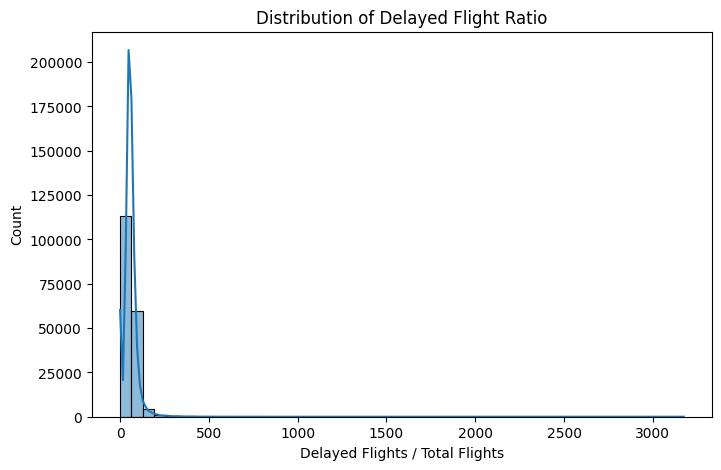

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['avg_delay_per_delayed_flight'], bins=50, kde=True)
plt.title("Distribution of Delayed Flight Ratio")
plt.xlabel("Delayed Flights / Total Flights")
plt.show()

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
year,178747.0,2019.478604,2015.0,2018.0,2020.0,2022.0,2023.0,2.412093
month,178747.0,6.488411,1.0,3.0,6.0,10.0,12.0,3.464885
arr_flights,178747.0,329.371108,1.0,42.0,89.0,219.0,21977.0,932.209047
arr_del15,178747.0,58.709086,0.0,6.0,15.0,40.0,4176.0,164.378035
carrier_ct,178747.0,18.598619,0.0,1.97,5.42,14.73,1293.91,47.417686
weather_ct,178747.0,2.038589,0.0,0.0,0.22,1.63,266.42,6.899212
nas_ct,178747.0,17.118839,0.0,1.0,3.31,9.88,1884.42,56.315314
security_ct,178747.0,0.145511,0.0,0.0,0.0,0.0,58.69,0.702619
late_aircraft_ct,178747.0,20.807539,0.0,1.0,4.3,13.04,2069.07,64.95349
arr_cancelled,178747.0,6.827555,0.0,0.0,1.0,3.0,4951.0,41.471159


In [ ]:
percentile_99 = df['avg_delay_per_delayed_flight'].quantile(0.99)
print("99th Percentile:", percentile_99)



99th Percentile: 190.3840000000008


here data is skewed so i clip the data higher than the 99 percentile value

In [ ]:
df['avg_delay_per_delayed_flight'] = df['avg_delay_per_delayed_flight'].clip(upper=df['avg_delay_per_delayed_flight'].quantile(0.99))


In [ ]:

# 🎯 Define regression features and target
reg_features = [
    'arr_cancelled', 'arr_diverted',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
    'year', 'month', 'carrier', 'airport', 'arr_flights'
]
target = 'avg_delay_per_delayed_flight'

In [ ]:
# 🧹 Filter and encode df
df_reg = df[reg_features + [target]].copy()


In [ ]:
# 🔠 Label encode 'carrier' and 'airport'
le_carrier = LabelEncoder()
le_airport = LabelEncoder()
df_reg['carrier'] = le_carrier.fit_transform(df['carrier'])
df_reg['airport'] = le_airport.fit_transform(df['airport'])

In [ ]:
# 📦 Split into train and test
X = df_reg[reg_features]
y = df_reg[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 📊 Evaluation function
def report_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📉 {name}")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²  : {r2:.3f}")

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_test_orig = y_test

In [ ]:
# ✅ Display results
report_metrics("Linear Regression", y_test_orig, y_pred_lr)


📉 Linear Regression
MAE : 21.12
RMSE: 30.22
R²  : 0.016


In [ ]:
# ✅ 1. Train the Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=150,       # number of trees
    max_depth=10,           # control overfitting
    min_samples_split=4,    # control overfitting
    random_state=42
)
rf.fit(X_train, y_train)

# ✅ 2. Predict
y_pred_rf = rf.predict(X_test)

# ✅ 3. Evaluation
print("\n🌲 Random Forest Regression Results")
print("MAE :", round(mean_absolute_error(y_test, y_pred_rf), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_rf)), 2))
print("R²  :", round(r2_score(y_test, y_pred_rf), 3))


🌲 Random Forest Regression Results
MAE : 16.58
RMSE: 25.06
R²  : 0.323


In [ ]:
from xgboost import XGBRegressor

# 🌲 Define XGBoost model
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 🏋️ Train
xgb_model.fit(X_train, y_train)

# 📈 Predict
y_pred_xgb = xgb_model.predict(X_test)

# 📊 Evaluation
print("\n🚀 XGBoost Regressor Results")
print("MAE :", round(mean_absolute_error(y_test, y_pred_xgb), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_xgb)), 2))
print("R²  :", round(r2_score(y_test, y_pred_xgb), 3))


🚀 XGBoost Regressor Results
MAE : 15.76
RMSE: 24.12
R²  : 0.373


##XGBoost gives better results

In [ ]:
# Evaluate metrics
results = []

# Linear Regression
results.append({
    "Model": "Linear Regression",
    "MAE": round(mean_absolute_error(y_test, y_pred_lr), 2),
    "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred_lr)), 2),
    "R²": round(r2_score(y_test, y_pred_lr), 3)
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "MAE": round(mean_absolute_error(y_test, y_pred_rf), 2),
    "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred_rf)), 2),
    "R²": round(r2_score(y_test, y_pred_rf), 3)
})

# XGBoost
results.append({
    "Model": "XGBoost",
    "MAE": round(mean_absolute_error(y_test, y_pred_xgb), 2),
    "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred_xgb)), 2),
    "R²": round(r2_score(y_test, y_pred_xgb), 3)
})

# Display results
print("📊 Model Comparison Table\n")
print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
print("-" * 50)
for row in results:
    print(f"{row['Model']:<20} {row['MAE']:<10} {row['RMSE']:<10} {row['R²']:<10}")

📊 Model Comparison Table

Model                MAE        RMSE       R²        
--------------------------------------------------
Linear Regression    21.12      30.22      0.016     
Random Forest        16.58      25.06      0.323     
XGBoost              15.76      24.12      0.373     


###SHAP

In [ ]:
importances = rf.feature_importances_
feature_names = X_train.columns

# Actionability mapping (can be improved with domain expert input)
actionability_scores = {
    'carrier_ct': 0.9,
    'weather_ct': 0.1,
    'nas_ct': 0.5,
    'security_ct': 0.3,
    'late_aircraft_ct': 0.4,
    'arr_flights': 0.7,
    'arr_cancelled': 0.6,
    'arr_diverted': 0.4,
    'month': 0.6,
    'year': 0.2,
    'carrier': 0.5,
    'airport': 0.3
}

# Compute OAI = importance × actionability
oai = []
for i, f in enumerate(feature_names):
    a_score = actionability_scores.get(f, 0)
    oai.append((f, importances[i], a_score, importances[i] * a_score))

# Create and display DataFrame
oai_df = pd.DataFrame(oai, columns=['Feature', 'Importance', 'Actionability', 'OAI'])
oai_df = oai_df.sort_values(by='OAI', ascending=False)
print("📊 Operational Adjustability Index (OAI):")
print(oai_df)


📊 Operational Adjustability Index (OAI):
             Feature  Importance  Actionability       OAI
2         carrier_ct    0.380161            0.9  0.342145
6   late_aircraft_ct    0.173542            0.4  0.069417
4             nas_ct    0.109808            0.5  0.054904
9            carrier    0.097694            0.5  0.048847
11       arr_flights    0.054179            0.7  0.037925
3         weather_ct    0.103684            0.1  0.010368
0      arr_cancelled    0.015487            0.6  0.009292
8              month    0.012920            0.6  0.007752
10           airport    0.022681            0.3  0.006804
7               year    0.023242            0.2  0.004648
1       arr_diverted    0.005212            0.4  0.002085
5        security_ct    0.001391            0.3  0.000417


In [ ]:
!pip install shap

import shap

In [ ]:
from sklearn.preprocessing import LabelEncoder
le_carrier = LabelEncoder()
le_airport = LabelEncoder()
df['carrier_encoded'] = le_carrier.fit_transform(df['carrier'])
df['airport_encoded'] = le_airport.fit_transform(df['airport'])

In [ ]:
df_delayed = df[df['arr_delay'] > 0].copy()

In [ ]:
max_delay_minutes = 1440
df_delayed['arr_delay'] = df_delayed['arr_delay'].clip(upper=max_delay_minutes)
print(f"Handled outliers by clipping delays at {max_delay_minutes} minutes.")


Handled outliers by clipping delays at 1440 minutes.


In [ ]:
print("Implementing Operational Adjustability Index (OAI) via sample weights...")
controllable_weight = 2.0  # Give more weight to controllable delays
external_weight = 1.0    # Normal weight for external delays

Implementing Operational Adjustability Index (OAI) via sample weights...


In [ ]:
total_controllable_delay = df_delayed['carrier_delay'] + df_delayed['late_aircraft_delay']
prop_controllable = (total_controllable_delay / df_delayed['arr_delay']).fillna(0)
# Assign a weight to each sample based on the OAI
sample_weights = (prop_controllable * controllable_weight +
                          (1 - prop_controllable) * external_weight)

print("Sample weights calculated to prioritize controllable delays.")

Sample weights calculated to prioritize controllable delays.


In [ ]:
features = ['year', 'month', 'carrier_encoded', 'airport_encoded', 'arr_flights']

In [ ]:
X_reg = df_delayed[features]
y_reg = df_delayed['arr_delay']

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r, sample_weights_train, sample_weights_test = train_test_split(
    X_reg, y_reg, sample_weights, test_size=0.3, random_state=42)

In [ ]:
import xgboost as xgb

# Train with sample weights to prioritize controllable delays
regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
regressor.fit(X_train_r, y_train_r, sample_weight=sample_weights_train)

# Predict
y_pred_r = regressor.predict(X_test_r)


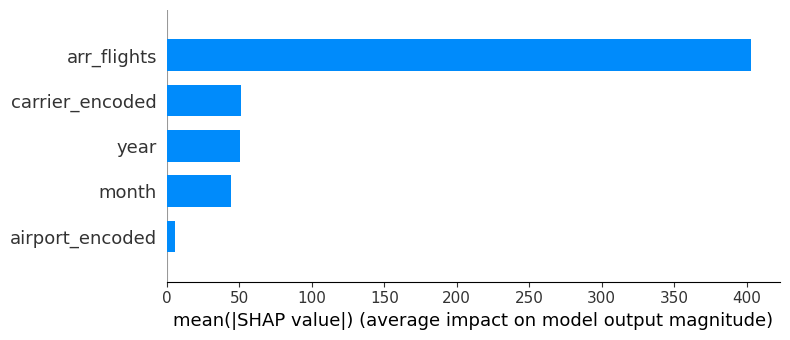

In [ ]:

# Initialize SHAP TreeExplainer
explainer = shap.Explainer(regressor)

# Compute SHAP values for test data
shap_values = explainer(X_test_r)

# Summary plot: average impact on model output
shap.summary_plot(shap_values, X_test_r, plot_type="bar")